In [1]:
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
import glob
import csv
import os
import tarfile
import math
import numpy as np 
from tqdm import tqdm
import json
import pickle as pkl
import networkx as nx
from __future__ import unicode_literals

In [3]:
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [4]:
print len(drug_association_graph.edges()) 
print len(drug_cat_association_graph.edges())
print len(drug_association_graph.nodes()) 
print len(drug_cat_association_graph.nodes())

7954
33493
4029
4047


In [16]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.h5')
print files

[u'../BL_Work/openPrescribe/savings/201011.h5', u'../BL_Work/openPrescribe/savings/201706.h5', u'../BL_Work/openPrescribe/savings/201108.h5', u'../BL_Work/openPrescribe/savings/201608.h5', u'../BL_Work/openPrescribe/savings/201210.h5', u'../BL_Work/openPrescribe/savings/201301.h5', u'../BL_Work/openPrescribe/savings/201703.h5', u'../BL_Work/openPrescribe/savings/201605.h5', u'../BL_Work/openPrescribe/savings/201705.h5', u'../BL_Work/openPrescribe/savings/201111.h5', u'../BL_Work/openPrescribe/savings/201201.h5', u'../BL_Work/openPrescribe/savings/201905.h5', u'../BL_Work/openPrescribe/savings/201401.h5', u'../BL_Work/openPrescribe/savings/201708.h5', u'../BL_Work/openPrescribe/savings/201211.h5', u'../BL_Work/openPrescribe/savings/201604.h5', u'../BL_Work/openPrescribe/savings/201204.h5', u'../BL_Work/openPrescribe/savings/201901.h5', u'../BL_Work/openPrescribe/savings/201112.h5', u'../BL_Work/openPrescribe/savings/201404.h5', u'../BL_Work/openPrescribe/savings/201806.h5', u'../BL_Work

In [6]:
#Different functions to extract different data form the prescription 

def cleanStringofUTF(string):
    cleaned = string.replace('\xe8','e').replace('\xf6','o')
    return cleaned

def enrichdrugs(chem_dict , drugs):
    diabetes_drug_words = [drugs[k]['name'].lower() for k in drugs]
    for drug in chem_dict:
        Name = chem_dict[drug]['name'].replace('(','').replace(')','')
        slot1 = Name.lower().split('/')
        slot2 = Name.lower().split(' ')
        slot3 = Name.lower().split(' & ')
        common1 = set(diabetes_drug_words).intersection(slot1)
        common2 = set(diabetes_drug_words).intersection(slot2)
        common3 = set(diabetes_drug_words).intersection(slot3)
        
        if len(common1) > 0 or len(common2) > 0 or len(common3) > 0:
            print common1 , common2 , common3
            drugs[chem_dict[drug]['code']] = {'disease':'' , 'disease_given_drug':0.0 , 'matched_disease':'', 'name':chem_dict[drug]['name'].strip() }

            
            
def makeChemDict(BNF_Chem):
    chem_dict = {}
    for index, row in BNF_Chem.iterrows():
        chem_dict[row['UNII_drugbank']] = {}
        chem_dict[row['UNII_drugbank']]['name'] = row['NAME']
        chem_dict[row['UNII_drugbank']]['code'] = row['BNF_code']
    return chem_dict
    
def getDrugCategory(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Categories']) > 0:
            for cat in drugbankDict[k]['Categories']:
                matched_memo = []
                catString = cat.values()[0]#.split('\u2014')[-1]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:# == len(categorylist):
                        allMatched.append(k)
                        print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return list(set(allMatched)) , drugs


def getDrugforDiseaseDrugbank(categorylist, BNF_Chem, drugbankDict):
    allMatched = []
    drugs = {}
    chem_dict = makeChemDict(BNF_Chem)
    
    for k in drugbankDict:
        if len(drugbankDict[k]['Associations']) > 0:
            for cat in drugbankDict[k]['Associations']:
                matched_memo = []
                catString = cat.values()[0]
                t = catString.lower().strip()
                for categoryString in categorylist:
                    categoryString = categoryString.lower()
                    if t.find(categoryString) >= 0:
                        matched_memo.append(categoryString)
                if k in chem_dict:
                    if len(matched_memo) > 0:
                        allMatched.append(k)
                        print chem_dict[k]
                        drugs[chem_dict[k]['code']] = {}
                        drugs[chem_dict[k]['code']]['name'] = chem_dict[k]['name']
                        drugs[chem_dict[k]['code']]['matched_cat'] = categorylist
    enrichdrugs(chem_dict,drugs)               
    return  allMatched , drugs


def findDrugsForDisease(Graph, Disease, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Disease.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Disease.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'symptom':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_disease'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['disease'] = Disease
    enrichdrugs(chem_dict,drugs)
    return drugs


def generateConfidence(drugs,Graph):
    shared = []
    All = []
    denom = max(Graph.degree().values())
    for d in drugs:
        name = drugs[d]['name']
        for e in Graph.edges(data=True):
            if Graph.node[e[0]]['type'] == 'symptom':
                if e[1] == name:
                    shared.append(Graph.degree()[e[1]]-1)
                else:
                    continue
            else:
                
                if e[0] == name:
                    shared.append(Graph.degree()[e[0]]-1)
                else:
                    continue
#     shared = [float(k) for k in shared]
    num = [k for k in shared if k > 1]

    return float(len(num)+1.0)/float(len(shared)+1.0)
#     return float(len(num))/float(len(shared)) * 10.0
#     return len(num)
                
                
def findDrugsForCategory(Graph, Cat, BNF_Chem ):#,threshProb):
    chem_dict = makeChemDict(BNF_Chem)
    drugs = {}
    for e in Graph.edges(data=True):
        if (cleanStringofUTF(e[1]).lower().find(Cat.lower()) >=0) or (cleanStringofUTF(e[0]).lower().find(Cat.lower()) >= 0) :
            drugNode = ''
            matchedDisease = ''
            if Graph.node[e[0]]['type'] == 'category':
                drugNode = e[1]
                matchedDisease = e[0]
            else:
                drugNode = e[0]
                matchedDisease = e[1]
            print Graph.node[drugNode]['Id']
            drugs[Graph.node[drugNode]['Id']] = {}
            drugs[Graph.node[drugNode]['Id']]['name'] = drugNode
            drugs[Graph.node[drugNode]['Id']]['matched_cat'] = matchedDisease
            drugs[Graph.node[drugNode]['Id']]['category'] = Cat
    enrichdrugs(chem_dict,drugs)
    return drugs

def findDrugByName(Graph, name):
    foundDrugs = []
    for node in Graph.nodes(data=True):
        if node[1]['type'] == 'drug':
            if name.lower() in node[0].lower().split(' '):
                foundDrugs.append(node)
    return foundDrugs

def relabelNodes(graph):
    mapping = {}
    for node in graph.nodes():
        mapping[node] = cleanStringofUTF(node)
        
    return nx.relabel_nodes(graph,mapping)


def readChem(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('CHEM') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

def readAddress(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('ADDR') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

def readPrescriptions(year,files):
    for f in files:
        if f.find(year)>0:
            if f.find('PDPI') > 0:
                df = pd.read_csv(f,compression='infer',header=None,skiprows=1)
                return df

In [7]:
# chem = readChem('201601',files)
chem = pd.read_csv('../BL_Work/CHEM_MASTER_MAP.csv')
len(chem)

# chem = chem.dropna()

matched = chem[chem['UNII_drugbank']!='[]']

matchedMap = {}
for index,row in matched.iterrows():
    if row['UNII_drugbank'] not in matchedMap:
         matchedMap[row['UNII_drugbank']] = []
    matchedMap[row['UNII_drugbank']].append(row['BNF_code'])

In [8]:
notMatched = chem[chem['UNII_drugbank']=='[]']

In [9]:
len(matched),len(notMatched)

(2321, 1111)

In [10]:
drugbank_dict = json.load(open('scratchpad/Drugbank_drugs_data.json','rb'))

In [11]:
condition_Association_map = {}
for k in drugbank_dict:
    if len(drugbank_dict[k]['Associations']) > 0:
        for ass in drugbank_dict[k]['Associations']:
            
            disease = ass[ass.keys()[0]]
            if disease not in condition_Association_map:
                condition_Association_map[disease] = []
            condition_Association_map[disease].append(drugbank_dict[k]['Name'])
    

category_Association_map = {}
for k in drugbank_dict:
    if len(drugbank_dict[k]['Categories']) > 0:
        for ass in drugbank_dict[k]['Categories']:
            
            disease = ass[ass.keys()[0]]
            if disease not in category_Association_map:
                category_Association_map[disease] = []
            category_Association_map[disease].append(drugbank_dict[k]['Name'])

In [12]:
commonKeys = set(drugbank_dict.keys()).intersection(matchedMap.keys())

category_BNF_map = {}
for k in commonKeys:
    if len(drugbank_dict[k]['Categories']) > 0:
        for ass in drugbank_dict[k]['Categories']:
            
            disease = ass[ass.keys()[0]]
            if disease not in category_BNF_map:
                category_BNF_map[disease] = []
            BNF_code = matched
            category_BNF_map[disease]+=matchedMap[k]

In [13]:
category_Association_map

{u'Curare Alkaloids': [u'Alcuronium', u'Tubocurarine'],
 u'Vitamins': [u'Riboflavin',
  u'Methylcobalamin',
  u'Pyridoxal phosphate',
  u'CholecalciferolCommonly known or available as Vitamin D3',
  u'Calcifediol',
  u'Leucovorin',
  u'Calcipotriol',
  u'Aminobenzoic acid',
  u'Levoleucovorin',
  u'Paricalcitol',
  u'Tocofersolan',
  u'Niacin',
  u'Lipoic Acid',
  u'Zinc ascorbate',
  u'Cobamamide',
  u'Nikethamide',
  u'Benfotiamine',
  u'Sorafenib',
  u'Motretinide',
  u'Ergocalciferol',
  u'Folic acid',
  u'Tretinoin',
  u'Alitretinoin',
  u'Tocopherol',
  u'Biotin',
  u'Dexpanthenol',
  u'Pantothenic acid',
  u'Inositol',
  u'Dihydrotachysterol',
  u'Sulbutiamine',
  u'Beta carotene',
  u'Hydroxocobalamin',
  u'Alfacalcidol',
  u'Ascorbic acidCommonly known or available as Vitamin C',
  u'CyanocobalaminCommonly known or available as Vitamin B12',
  u'Inositol nicotinate',
  u'PhylloquinoneCommonly known or available as Vitamin K1',
  u'Vitamin A',
  u'Pantethine',
  u'Doxercalcifer

In [14]:
condition_Association_map

{u'Lower respiratory tract infection caused by penicillin-susceptible Streptococcus pneumoniae': [u'Ciprofloxacin'],
 u'Dermatographic urticaria': [u'Cyproheptadine'],
 u'Moderate to Severe Asthma': [u'Dupilumab'],
 u'Stress Urinary Incontinence (SUI)': [u'Duloxetine'],
 u'Altered regional cerebral perfusion in stroke': [u'Technetium Tc-99m exametazime'],
 u'Recalcitrant Dermatophytosis': [u'Ketoconazole'],
 u'Proliferating Infantile Hemangioma': [u'Propranolol'],
 u'Premenstrual Dysphoric Disorder': [u'Fluoxetine',
  u'Sertraline',
  u'Paroxetine',
  u'Ethinylestradiol',
  u'Drospirenone',
  u'Citalopram'],
 u'Phenylketonuria (PKU)': [u'Sapropterin'],
 u'CNS Infection': [u'Metronidazole'],
 u'Venous Thromboembolism (VTE)': [u'Tinzaparin',
  u'Nadroparin',
  u'Heparin',
  u'Dalteparin',
  u'Acetylsalicylic acidCommonly known or available as Aspirin'],
 u'Urinary tract infection caused by klebsiella': [u'Pivmecillinam'],
 u'Acute Myelocytic Leukemia': [u'Cyclophosphamide'],
 u'Acute max

In [19]:
drugbank_dict

{u'JWF5YAW3QW': {u'ATC_Codes': [{u'/atc/N05CM09': u'N05CM09 \u2014 Valerianae radix'},
   {u'/atc/N05CM': u'N05CM \u2014 Other hypnotics and sedatives'},
   {u'/atc/N05C': u'N05C \u2014 HYPNOTICS AND SEDATIVES'},
   {u'/atc/N05': u'N05 \u2014 PSYCHOLEPTICS'},
   {u'/atc/N': u'N \u2014 NERVOUS SYSTEM'}],
  u'Associations': [],
  u'Categories': [{u'/categories/DBCAT000399': u'Central Nervous System Depressants'},
   {u'/categories/DBCAT003727': u'Herbs and Natural Products'},
   {u'/categories/DBCAT000452': u'Hypnotics and Sedatives'},
   {u'/categories/DBCAT003678': u'Miscellaneous Anxiolytics Sedatives and Hypnotics'},
   {u'/categories/DBCAT002148': u'Nervous System'},
   {u'/categories/DBCAT002185': u'Psycholeptics'}],
  u'Name': u'Valerian'},
 u'JCV8365FWN': {u'ATC_Codes': [{u'/atc/C04AE02': u'C04AE02 \u2014 Nicergoline'},
   {u'/atc/C04AE': u'C04AE \u2014 Ergot alkaloids'},
   {u'/atc/C04A': u'C04A \u2014 PERIPHERAL VASODILATORS'},
   {u'/atc/C04': u'C04 \u2014 PERIPHERAL VASODILAT

In [17]:
pdp = pd.read_hdf(files[0])
pdp.dropna()
for file in files[0:0+3]:
    pdp2 = pd.read_hdf(file)
    pdp2.dropna()
    pdp.append(pdp2)

In [18]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 36532   38859       Q30  5D7  A86040  0101010C0BBAAAA   
  48660   52984       Q30  5D8  A87005  0101010C0AAAAAA   
  96820   106204      Q30  5E1  A81025  0101010C0BBAAAA   
  106428  115812      Q30  5E1  A81046  0101010C0BBAAAA   
  123754  135423      Q30  5J9  A83031  0101010C0AAAAAA   

                                                 4    5     6     7      8  \
0 36532   Alu-Cap_Cap 475mg                         1.0  3.75  3.48  120.0   
  48660   Alum Hydrox_Cap 475mg                     1.0  3.75  3.48  120.0   
  96820   Alu-Cap_Cap 475mg                         1.0  2.63  2.45  84.0    
  106428  Alu-Cap_Cap 475mg                         1.0  1.75  1.64  56.0    
  123754  Alum Hydrox_Cap 475mg                     1.0  5.25  4.86  168.0   

          ...                   14     15         16    17   18    19  20  \
0 36532   ...  Aluminium Hydroxide  475.0  0101010C0  15.0  1.0  15.0  BB   
  48660   ...  Aluminium Hydroxide  475.0  0101010C0  15.0  1.0  15.0  AA   
  96820   ...  Aluminium Hydroxide  475.0  0101010C0  10.5  1.0  10.5  BB   
  106428  ...  Aluminium Hydroxide  475.0  0101010C0  7.0   1.0  7.0   BB   
  123754  ...  Aluminium Hydroxide  475.0  0101010C0  21.0  1.0  21.0  AA   

             21      22     23  
0 36532   0.029  0.0325  0.420  
  48660   0.029  0.0325  0.420  
  96820   0.029  0.0325  0.294  
  106428  0.029  0.0325  0.196  
  123754  0.029  0.0325  0.588  

[5 rows x 25 columns]

In [22]:
BNF_Drug_name = {}
BNF_Associations = {}
for UNI_key in matchedMap:
    for bnf in matchedMap[UNI_key]:
        if UNI_key in drugbank_dict:
            BNF_Drug_name[bnf] = drugbank_dict[UNI_key]['Name']
            BNF_Associations[bnf] = drugbank_dict[UNI_key]['Associations']

In [23]:
BNF_Drug_name

{'0204000X0': u'Nadolol',
 '1304000K0': u'Dexamethasone',
 '0901012I0': u'Iron',
 '0102000L0': u'Glycopyrronium',
 '0205040S0': u'Prazosin',
 '1002010Q0': u'Pyridostigmine',
 '0411000E0': u'Rivastigmine',
 '0205051E0': u'Cilazapril',
 '1202010T0': u'Triamcinolone',
 '1310011I0': u'Isoniazid',
 '0604020C0': u'Finasteride',
 '0202080B0': u'Potassium',
 '1501010C0': u'Etomidate',
 '0301020B0': u'Atropine',
 '0502000AC': u'Micafungin',
 '0502000AB': u'Anidulafungin',
 '0502000AA': u'Posaconazole',
 '0605010M0': u'Urofollitropin',
 '0803042A0': u'Bicalutamide',
 '0204000A0': u'Atenolol',
 '0604011N0': u'Estradiol',
 '1103010U0': u'Sulfacetamide',
 '0601021M0': u'Gliclazide',
 '0501110N0': u'Ornidazole',
 '1310050M0': u'Magnesium sulfate',
 '0407020X0': u'Phenazocine',
 '0501040F0': u'Framycetin',
 '0704040J0': u'Sodium chloride',
 '0501070H0': u'Colistin',
 '0408010U0': u'Primidone',
 '0605010L0': u'Cyclofenil',
 '0403010B0': u'Amitriptyline',
 '0801050V0': u'Paclitaxel',
 '1305020T0': u'Ta

In [24]:
BNF_Associations

{'0204000X0': [{u'/indications/DBCOND0027898': u'Angina Pectoris'},
  {u'/indications/DBCOND0024761': u'Gastroesophageal variceal hemorrhage prophylaxis'},
  {u'/indications/DBCOND0040789': u'High Blood Pressure (Hypertension)'},
  {u'/indications/DBCOND0017962': u'Migraine'},
  {u'/indications/DBCOND0040606': u'Nonvalvular Atrial Fibrillation'},
  {u'/indications/DBCOND0021770': u'Thyrotoxicosis'}],
 '1304000K0': [{u'/indications/DBCOND0029985': u'Acne Rosacea'},
  {u'/indications/DBCOND0032167': u'Acute Gouty Arthritis'},
  {u'/indications/DBCOND0025987': u'Adrenal cortical hypofunctions'},
  {u'/indications/DBCOND0059917': u'Adrenocortical Hyperfunction'},
  {u'/indications/DBCOND0071530': u'Alopecia Areata (AA)'},
  {u'/indications/DBCOND0046486': u'Ankylosing Spondylitis (AS)'},
  {u'/indications/DBCOND0067874': u'Anterior Segment Inflammation'},
  {u'/indications/DBCOND0075845': u'Aspiration Pneumonitis'},
  {u'/indications/DBCOND0072519': u'Asthma Bronchial'},
  {u'/indications/

In [54]:
drug_freq_dict = {'drug_name':[] , 'presc_count' : [] , 'Conditions' : [],'BNF':[]}

for name , group in pdp.groupby('16'):
    if name in BNF_Drug_name:
        drug_freq_dict['drug_name'].append(BNF_Drug_name[name])
        drug_freq_dict['BNF'].append(name)
        drug_freq_dict['presc_count'].append(len(group))
        drug_freq_dict['Conditions'].append([d[d.keys()[0]] for d in BNF_Associations[name]])

In [65]:
drug_freq_dict = {'drug_name':[] , 'Conditions' : [] , 'BNF':[]}

for name , group in pdp.groupby('16'):
    if name in BNF_Drug_name:
        for condition in BNF_Associations[name]:
            drug_freq_dict['drug_name'].append(BNF_Drug_name[name])
            drug_freq_dict['BNF'].append(name)
            drug_freq_dict['Conditions'].append(condition[condition.keys()[0]])

In [66]:
Lucia_data_df = pd.DataFrame.from_dict(drug_freq_dict)

In [70]:
Lucia_data_df.to_csv('BNF_Condition_drug_mapping.csv',encoding = 'utf-16')

In [55]:
drug_freq_df = pd.DataFrame.from_dict(drug_freq_dict)

In [56]:
drug_freq_df.head()

,BNF,Conditions,drug_name,presc_count
0,0101010E0,[],Hydrotalcite,9
1,0101010F0,"[Acid indigestion, Bladder calculus, Heartburn, Renal Stones, Upset stomach]",Magnesium carbonate,47
2,0101010I0,"[Acid indigestion, Heartburn]",Magnesium oxide,223
3,0101010N0,[Acid Reflux],Oxetacaine,1
4,0101010Q0,"[Acid indigestion, Heartburn, Occasional Constipation, Sour stomach, Upset stomach]",Magnesium hydroxide,75


In [61]:
sorted_drug_freq_df = drug_freq_df.sort_values('presc_count',ascending = False)

In [63]:
sorted_drug_freq_df.head(n = 10)

,BNF,Conditions,drug_name,presc_count
163,0206020C0,"[Anal Fissures, Angina Pectoris, Variant, Anginal Pain, Atrial Flutter, Chronic Stable Angina Pectoris, High Blood Pressure (Hypertension), Idiopathic Dilated Cardiomyopathy, Nonvalvular Atrial Fibrillation, Paroxysmal Supraventricular Tachycardia, Proteinuria, Pulmonary Hypertension (PH), Leg cramps, Prophylaxis of migraine headaches]",Diltiazem,86643
233,0302000N0,[],Fluticasone,84983
1062,1304000V0,"[Acute Gouty Arthritis, Allergic Rhinitis (AR), Allergic corneal marginal ulcers, Ankylosing Spondylitis (AS), Anterior Segment Inflammation, Aspiration Pneumonitis, Asthma Bronchial, Atopic Dermatitis (AD), Berylliosis, Bullous dermatitis herpetiformis, Congenital Adrenal Hyperplasia (CAH), Conjunctivitis, Seasonal Allergic, Corneal Inflammation, Crohn's Disease (CD), Dermatitis, Contact, Dermatomyositis, Dermatosis, Drug hypersensitivity reaction, Epicondylitis, Erythroblastopenia, Hypercalcemia of Malignancy, Idiopathic Thrombocytopenic Purpura (ITP), Iridocyclitis, Iritis, Leukemia, Acute, Leukemias, Loeffler's syndrome, Malignant Lymphomas, Mycosis Fungoides (MF), Ophthalmia, Sympathetic, Optic Neuritis, Pemphigus, Primary adrenocortical insufficiency, Proteinuria, Psoriatic Arthritis, Rheumatic heart disease, unspecified, Rheumatoid Arthritis, Rheumatoid Arthritis, Juvenile, Secondary adrenocortical insufficiency, Secondary thrombocytopenia, Serum Sickness, Severe Seborrheic Dermatitis, Stevens Johnson Syndrome, Synovitis, Systemic Lupus Erythematosus (SLE), Trichinosis, Tuberculous Meningitis, Ulcerative Colitis (UC), Acquired immune hemolytic anemia, Acute Bursitis, Acute Tenosynovitis, Diffuse posterior uveitis, Disseminated Pulmonary Tuberculosis, Exfoliative erythroderma, Fulminating Pulmonary Tuberculosis, Non-suppurative Thyroiditis, Severe Psoriasis, Subacute Bursitis, Symptomatic Sarcoidosis, Systemic Dermatomyositis, Varicella-zoster virus acute retinal necrosis]",Hydrocortisone,64713
218,0301011R0,"[Bronchospasm, Exercise-Induced Bronchoconstriction (EIB), Hyperkalemia]",Salbutamol,63888
841,0906040N0,"[Hypophosphatemia, Familial, Vitamin D Resistant Rickets, Parathyroid deficiency]",Ergocalciferol,62415
1054,1304000F0,"[Acute Gouty Arthritis, Adrenal cortical hypofunctions, Alopecia Areata (AA), Ankylosing Spondylitis (AS), Berylliosis, Bullous dermatitis herpetiformis, Bursitis, Congenital Adrenal Hyperplasia (CAH), Congenital Hypoplastic Anemia, Dermatomyositis, Dermatosis, Discoid Lupus Erythematosus (DLE), Edema of the cerebrum, Epicondylitis, Glomerulonephritis minimal lesion, Hypercalcemia of Malignancy, Keloid Scars, Leukemias, Lichen Planus (LP), Lichen simplex chronicus, Lupus Erythematosus, Malignant Lymphomas, Multiple sclerosis exacerbation, Mycosis Fungoides (MF), Necrobiosis lipoidica diabeticorum, Ophthalmia, Sympathetic, Pemphigus, Plaque psoriasis of the body, Plaque psoriasis of the scalp, Polymyositis, Psoriatic Arthritis, Psoriatic plaque, Pulmonary Tuberculosis (TB), Pure Red Cell Aplasia, Regional Enteritis, Rheumatoid Arthritis, Rheumatoid Arthritis, Juvenile, Secondary thrombocytopenia, Severe Asthma, Severe Atopic Dermatitis, Stevens Johnson Syndrome, Systemic Lupus Erythematosus (SLE), Temporal Arteritis, Trichinosis, Tuberculous Meningitis, Ulcerative Colitis (UC), Uveitis, Acquired immune hemolytic anemia, Acute nonspecific tenosynovitis, Acute rheumatic carditis, Exfoliative erythroderma, Granuloma annulare lesions, Idiopathic eosinophilic pneumonias, Non-suppurative Thyroiditis, Ocular inflammatory conditions, Severe Allergic rhinitis, Severe Contact dermatitis, Severe Serum sickness, Severe Transfusion Reactions, Severe drug hypersensitivity reactions, Symptomatic Sarcoidosis, Synovitis of osteoarthritis]",Betamethasone,60061
170,0206020R0,"[Chronic Stable Angina Pectoris, High Blood Pressure (Hypertension), Hypertensive Emergency, Premature Labour, Pulmonary Edemas, Pulmonary Hypertension (PH), Raynaud's Phenomenon, Ureteral Ca

In [33]:
import seaborn as sns

Text(0,0.5,u'Prescriptions found over 3 months')

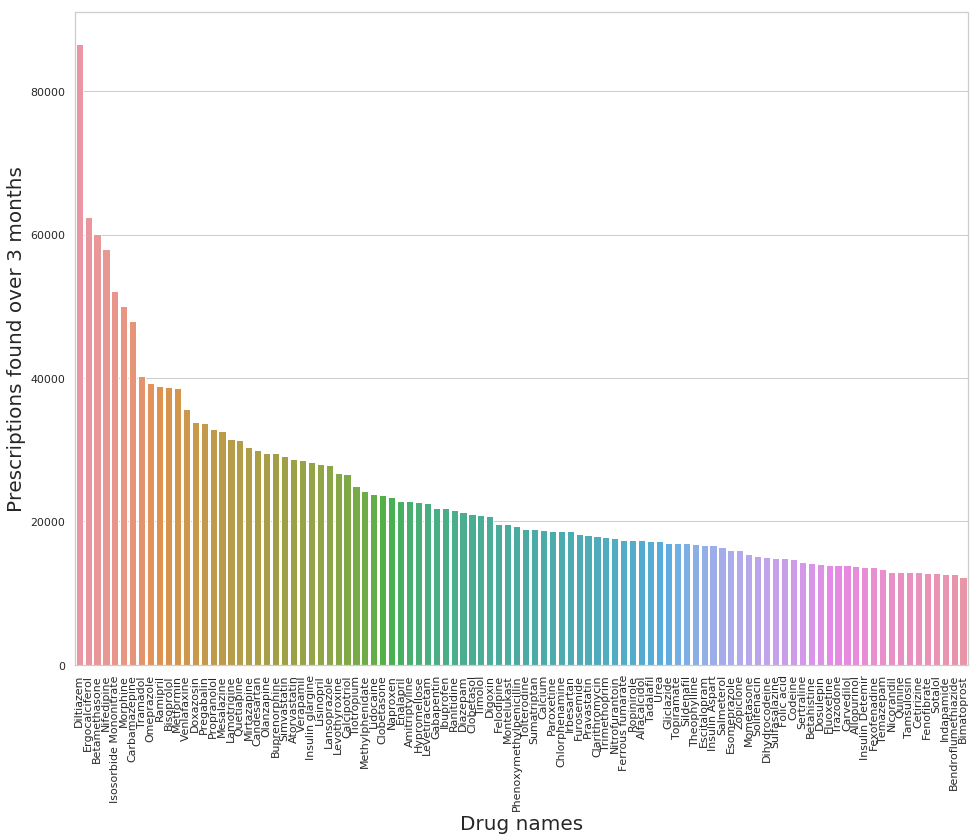

In [43]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
x = [item[0] for item in sorted_drug_freq_dict[:100]]
y = [item[1] for item in sorted_drug_freq_dict[:100]]
ax = sns.barplot(x=x, y=y)
plt.xticks(rotation = 90)
plt.xlabel('Drug names', fontsize = 20)
plt.ylabel('Prescriptions found over 3 months', fontsize = 20)

In [44]:
condition_freq_dict = {}
for name , group in pdp.groupby('16'):
    if name in BNF_Drug_name:
        drug_freq_dict[BNF_Drug_name[name]] = len(group)

KeyError: u'Diltiazem'